In [1]:
import os
import argparse
import matplotlib.pyplot as plt
import torch
from data import StratifiedGroupKFoldDataModule
import cv2 as cv
from pathlib import Path
from models.base import BaseModel
from models.resnet import ResNetModel
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

In [23]:
parser = argparse.ArgumentParser()
group = parser.add_argument_group("qt.coyote")
group.add_argument("--batch_size", help="Batch size", type=int, default=32)
group.add_argument(
    "--learning_rate", help="Learning rate", type=float, default=1e-3
)
group.add_argument(
    "--k",
    help="Number of folds in k-fold cross validation",
    type=int,
    default=5,
)
group.add_argument(
    "--internal_k",
    help="Number of folds for train/test split",
    type=int,
    default=5,
)
group.add_argument(
    "--no_external_group",
    help="Use grouped k-fold cross validation in external k-fold cross validation",
    action="store_true",
)
group.add_argument(
    "--internal_group",
    help="Use grouped k-fold cross validation in internal k-fold cross validation",
    action="store_true",
)
group.add_argument(
    "--data_path",
    help="Path to images",
    type=str,
    default="data",
)
group.add_argument(
    "--metadata_path",
    help="Path to COCO metadata file",
    type=str,
    default="data/qt-coyotes-merged.json",
)
group.add_argument(
    "--num_workers",
    help="Number of workers for dataloader",
    type=int,
    default=os.cpu_count() - 2,
)
group.add_argument(
    "--persistent_workers",
    help="If True, the data loader will not shutdown the worker processes "
    "after a dataset has been consumed once. This allows to maintain the "
    "workers Dataset instances alive.",
    type=bool,
    default=True,
)
group.add_argument(
    "--shuffle",
    help="Whether to shuffle each class's samples before splitting into "
    "batches. Note that the samples within each split will not be "
    "shuffled. This implementation can only shuffle groups that have "
    "approximately the same y distribution, no global shuffle will be "
    "performed.",
    type=bool,
    default=True,
)
group.add_argument(
    "--random_state",
    help="When shuffle is True, random_state affects the ordering of the "
    "indices, which controls the randomness of each fold for each class. "
    "Otherwise, leave random_state as None. Pass an int for reproducible "
    "output across multiple function calls.",
    type=int,
    default=42,
)
group.add_argument(
    "--nondeterministic",
    help="This flag sets the torch.backends.cudnn.deterministic flag to false",
    action="store_true",
)
group.add_argument(
    "--nonpretrained",
    help="Do not use pretrained weights, train from scratch",
    action="store_true",
)
group.add_argument(
    "--compile",
    help="Compile the model",
    action="store_true",
)
group.add_argument(
    "--no_early_stopping",
    help="Disable early stopping",
    action="store_true",
)
group.add_argument(
    "--no_crop",
    help="Disable cropping",
    action="store_true",
)
group.add_argument(
    "--no_data_augmentation",
    help="Disable data augmentation",
    action="store_true",
)
group.add_argument(
    "--patience",
    help="Number of checks with no improvement after which training will be stopped.",
    type=int,
    default=5,
)
group.add_argument(
    "--scheduler_factor",
    help="Factor by which the lr will be decreased",
    type=float,
    default=0.5,
)
group.add_argument(
    "--scheduler_patience",
    help="Number of checks with no improvement after which lr will decrease",
    type=int,
    default=4,
)
group.add_argument(
    "--yolo_model",
    help="Yolo pretrained model",
    type=str,
    default="yolov8n-cls.pt",
)
group.add_argument(
    "--resnet_model",
    help="ResNet model",
    type=str,
    default="ResNet18",
)
group.add_argument(
    "--densenet_model",
    help="DenseNet model",
    type=str,
    default="DenseNet121",
)
group.add_argument(
    "--crop_size",
    help="Crop size",
    type=int,
    default=224,
)
group.add_argument(
    "--criterion_pos_weight",
    help="Weight for positive class for BCEWithLogitsLoss",
    type=float,
    default=10.0
)
group.add_argument(
    "--criterion_beta",
    help="Beta for F-beta loss",
    type=float,
    default=5.0
)
group.add_argument(
    "--criterion_cfn",
    help="Cost false negative for ExpectedCostLoss",
    type=float,
    default=5.0
)
group.add_argument(
    "--dropout_p",
    help="Dropout probability",
    type=float,
    default=0.2,
)
group.add_argument(
    "--tabular_hidden_size",
    help="Size of the tabular hidden layers",
    type=int,
    default=32,
)
group.add_argument(
    "--no_tabular_features",
    help="Do not use tabular features",
    action="store_true",
)
args = parser.parse_args([])

In [4]:
import torchvision.transforms as transforms
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.GaussianBlur(3, sigma=(0.1, 2)),
    transforms.ColorJitter(
        brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1
    ),
])

In [ ]:
loss = BCEWithLogitsLoss()
model = ResNetModel(loss, args)
print(model.feature_extractor)

In [15]:
# Test for external k-fold cross validation leakage of groups
datamodule = StratifiedGroupKFoldDataModule(args)
datamodule.prepare_data()
datamodule.setup(None)

locations = {}

for i, datamodule_i in tqdm(enumerate(datamodule)):
    train = datamodule_i.train_dataloader()
    val = datamodule_i.val_dataloader()
    test = datamodule_i.test_dataloader()
    train_locations = train.dataset.locations
    val_locations = val.dataset.locations
    test_locations = test.dataset.locations
    locations[i] = {
        "train": list(train_locations),
        "val": list(val_locations),
        "test": list(test_locations),
    }
    assert(test_locations.intersection(train_locations) == set())
    assert(test_locations.intersection(val_locations) == set())


import json
with open("locations.json", "w") as f:
    json.dump(locations, f, indent=4)

5it [00:00, 838.49it/s]


In [8]:
train.dataset.locations

{'CBW',
 'CPR',
 'CTG',
 'DAP',
 'FRM',
 'FSP',
 'Falconer::A',
 'Falconer::B',
 'GOF',
 'Kinnard::A',
 'Kinnard::B',
 'LEW',
 'LIM',
 'LPP',
 'MMP',
 'PAP',
 'RES',
 'Rowland::C',
 'Rowland::F',
 'Rowland::L',
 'Rowland::N',
 'SMC',
 'SMI',
 'STJ',
 'Strathearn::A',
 'Strathearn::B',
 'TUW09',
 'TUW09b',
 'TUW13',
 'TUW14',
 'TUW17',
 'TUW18',
 'TUW19',
 'TUW20',
 'TUW23',
 'TUW24',
 'TUW25',
 'TUW26',
 'TUW27',
 'TUW28',
 'TUW29',
 'TUW29b',
 'TUW33c',
 'TUW34',
 'TUW37',
 'TUW37b',
 'TUW39',
 'TUW4',
 'TUW40\\Checkup 8 date wrong',
 'TUW41\\Checkup 1',
 'TUW41\\Checkup 3',
 'TUW41\\Checkup 9 wrong date',
 'TUW42',
 'TUW4b',
 'TUW5',
 'TUW6',
 'TUW7',
 'TUWCPC_4\\check6_WW',
 'TUWCPC_5\\Checkup 1',
 'TUWCPC_5\\check4',
 'VLG',
 'VTW',
 'WBK',
 'WCP',
 'WDW',
 'WGL',
 'YHR'}

0it [00:00, ?it/s]/Users/steven/Github/mange-classifier/env/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Fold 0: train=11301, val=2826, test=633, total=14760


0it [00:00, ?it/s]
0it [00:17, ?it/s]


IndexError: index 4 is out of bounds for axis 0 with size 4

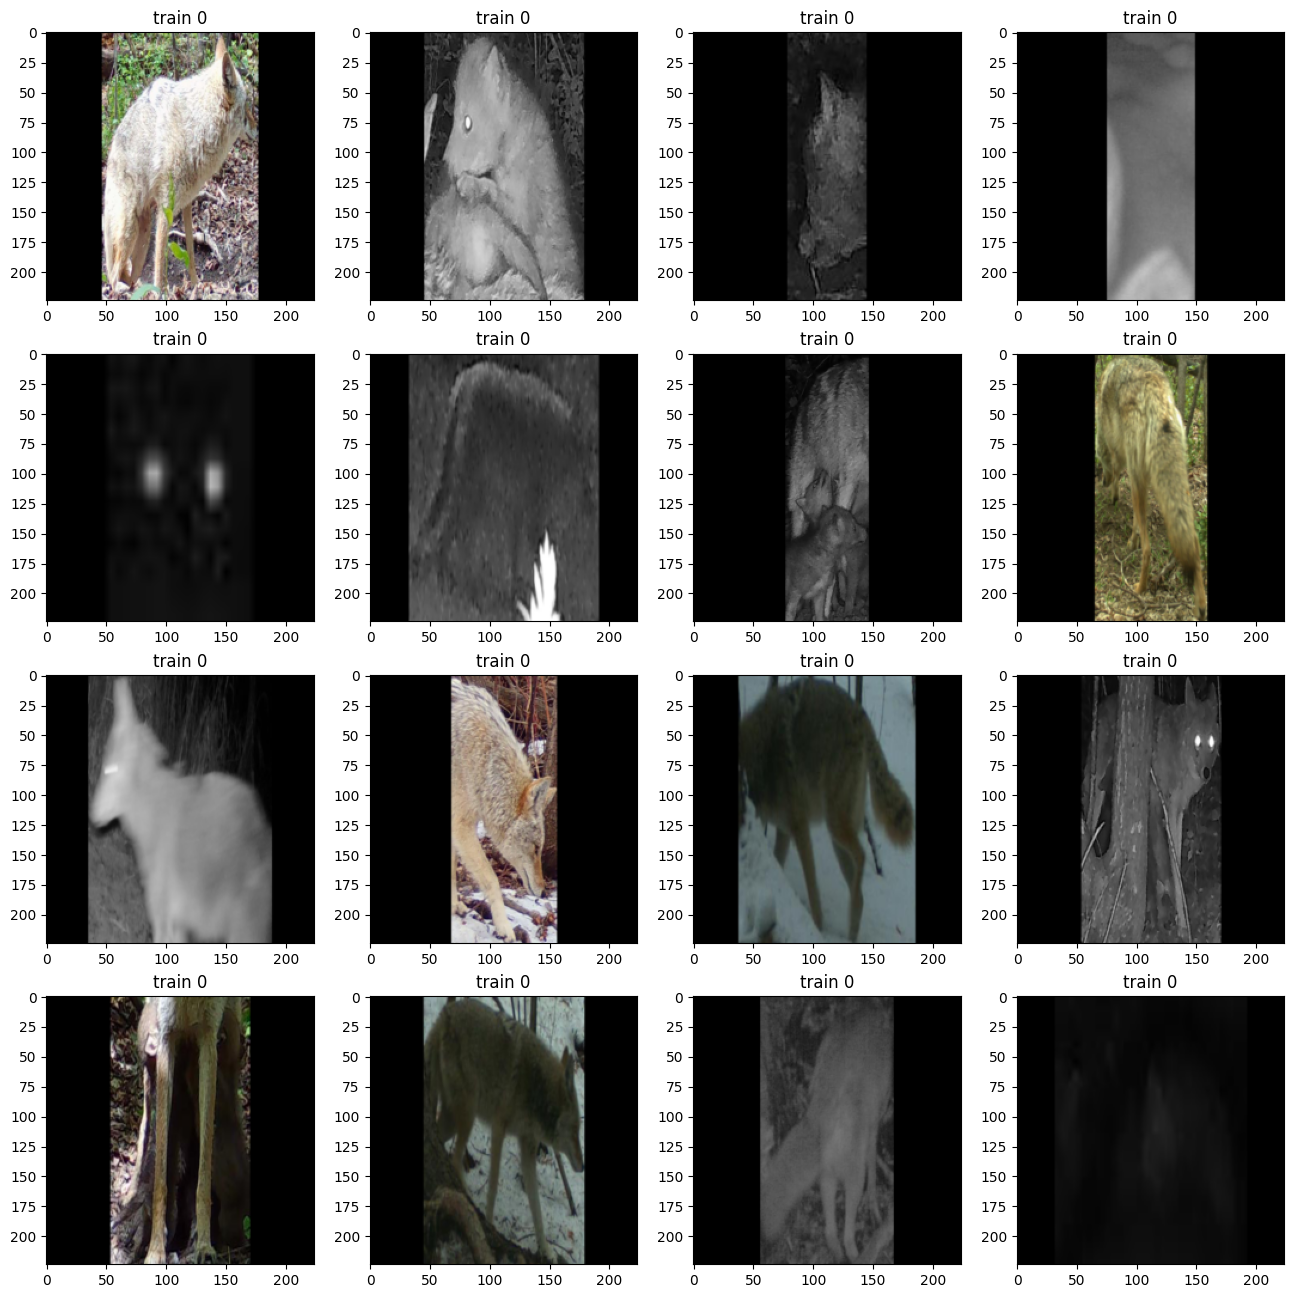

In [26]:
import glob
datamodule = StratifiedGroupKFoldDataModule(args)
datamodule.prepare_data()
datamodule.setup(None)

DEBUG_PATH = Path("data/debug")

criterion = BCEWithLogitsLoss()


for i, datamodule_i in tqdm(enumerate(datamodule)):
    train = datamodule_i.train_dataloader()
    val = datamodule_i.val_dataloader()
    test = datamodule_i.test_dataloader()
    ltrain = len(train.dataset)
    lval = len(val.dataset)
    ltest = len(test.dataset)
    print(f"Fold {i}: train={ltrain}, val={lval}, test={ltest}, total={ltrain+lval+ltest}")
    folder_path = DEBUG_PATH / f"fold_{i}"
    model_path = glob.glob(f"lightning_logs/version_{i}/checkpoints/*.ckpt")[0]
    model = ResNetModel(criterion, args)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))["state_dict"], strict=False)
    model.eval()
    for dataloader, stage in zip([train, val, test], ["train", "val", "test"]):
        stage_path = folder_path / stage

        for j, (X, Y) in tqdm(enumerate(dataloader)):
            fig, axs = plt.subplots(4, 4, figsize=(16, 16))
            for k, (i, t, y) in enumerate(zip(*X, Y)):
                image_path = stage_path / f"{y}/batch_{j}_{k}.png"
                image_path.parent.mkdir(parents=True, exist_ok=True)
                ax = axs[k // 4, k % 4]
                i = i.permute(1, 2, 0)
                cv.imwrite(str(image_path), i.numpy())
                ax.imshow(i)
                if stage == "test":
                    with torch.no_grad():
                        x = (i, t)
                        yhat = model(x)
                    ax.set_title(f"{stage} {yhat}: {y}")
                else:
                    ax.set_title(f"{stage} {y}")
            batch_path = stage_path / f"batch_{j}.png"
            batch_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(batch_path)
            plt.close()

            if stage == "test":
                continue
            Xa = augmentations(X[0])
            fig, axs = plt.subplots(4, 4, figsize=(16, 16))
            for k, (x, y) in enumerate(zip(Xa, Y)):
                i, t = x
                ax = axs[k // 4, k % 4]
                ax.imshow(i.permute(1, 2, 0))
                ax.set_title(f"{stage} {y}")
            batch_path = stage_path / f"batch_{j}_augmented.png"
            batch_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(batch_path)
            plt.close()
    
